In [1]:
import torch 
import umap 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
import seaborn as sbn 
from tkgdti.models.ComplEx2 import ComplEx2
import numpy as np 
import pandas as pd 

/home/teddy/miniconda3/envs/tkgdti/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_dir = '/home/teddy/local/workflow_outputs/tkgdti/12_10_25_complex2_predictions/complex2/FOLD_0/a899a0af-329f-4937-8906-61ad29be2b9e/'
data_dir = '/home/teddy/local/workflow_outputs/tkgdti/12_10_25_complex2_predictions/complex2/'

In [3]:
res = torch.load(f'{model_dir}/results.pt', map_location='cpu', weights_only=False)
data = torch.load(f'{data_dir}/Data.pt', map_location='cpu', weights_only=False)

In [4]:
model = ComplEx2(data, hidden_channels=res['config']['channels'], scale_grad_by_freq=False, dtype=torch.float32, dropout=0.)
model.load_state_dict(res['best_model'])
model.eval()

ComplEx2(
  (head_embedding_real_dict): ModuleDict(
    (disease): Embedding(6755, 512)
    (drug): Embedding(2893, 512)
    (gene): Embedding(16879, 512)
    (pathway): Embedding(2363, 512)
  )
  (head_embedding_imag_dict): ModuleDict(
    (disease): Embedding(6755, 512)
    (drug): Embedding(2893, 512)
    (gene): Embedding(16879, 512)
    (pathway): Embedding(2363, 512)
  )
  (tail_embedding_real_dict): ModuleDict(
    (disease): Embedding(6755, 512)
    (drug): Embedding(2893, 512)
    (gene): Embedding(16879, 512)
    (pathway): Embedding(2363, 512)
  )
  (tail_embedding_imag_dict): ModuleDict(
    (disease): Embedding(6755, 512)
    (drug): Embedding(2893, 512)
    (gene): Embedding(16879, 512)
    (pathway): Embedding(2363, 512)
  )
  (relation_real_embedding): Embedding(31, 512)
  (relation_imag_embedding): Embedding(31, 512)
)

In [5]:
z_gene_real = model.head_embedding_real_dict['gene'].weight.data.detach().cpu().numpy() 
z_gene_imag = model.head_embedding_imag_dict['gene'].weight.data.detach().cpu().numpy()  

z_gene = np.concatenate([z_gene_real, z_gene_imag], axis=1) 

z_dis_real = model.head_embedding_real_dict['disease'].weight.data.detach().cpu().numpy() 
z_dis_imag = model.head_embedding_imag_dict['disease'].weight.data.detach().cpu().numpy() 

z_dis = np.concatenate([z_dis_real, z_dis_imag], axis=1) 

z_pathway_real = model.head_embedding_real_dict['pathway'].weight.data.detach().cpu().numpy() 
z_pathway_imag = model.head_embedding_imag_dict['pathway'].weight.data.detach().cpu().numpy() 

z_pathway = np.concatenate([z_pathway_real, z_pathway_imag], axis=1) 

z_drug_real = model.head_embedding_real_dict['drug'].weight.data.detach().cpu().numpy() 
z_drug_imag = model.head_embedding_imag_dict['drug'].weight.data.detach().cpu().numpy() 

z_drug = np.concatenate([z_drug_real, z_drug_imag], axis=1) 

z = np.concatenate([z_gene, z_dis, z_pathway, z_drug], axis=0)  


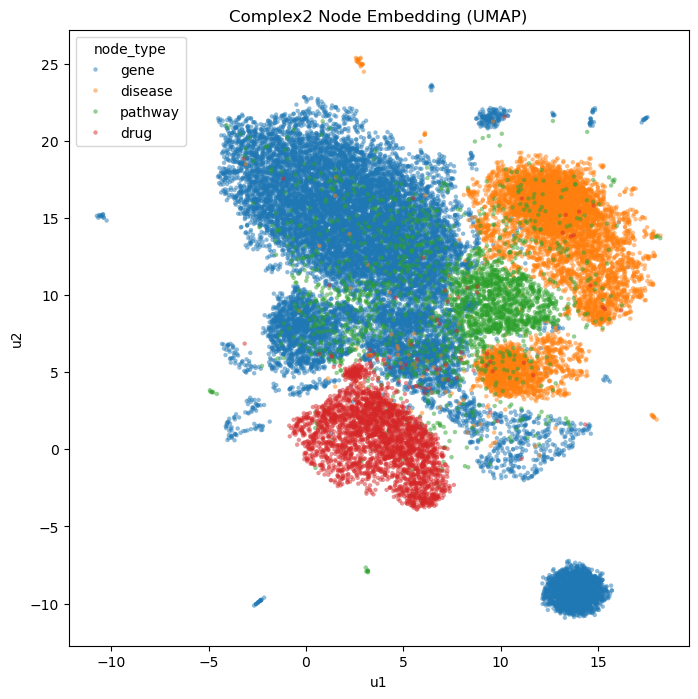

In [36]:
reducer = umap.UMAP(n_components=2, metric='cosine', n_neighbors=10,
                    min_dist=1., spread=1.0, n_epochs=1000)
#reducer = TSNE(n_components=2, perplexity=100)
u = reducer.fit_transform(z) 

df = pd.DataFrame(u, columns=['u1', 'u2'], 
                        index=data.node_name_dict['gene'].tolist() \
                            + data.node_name_dict['disease'].tolist() \
                                + data.node_name_dict['pathway'].tolist() \
                                    + data.node_name_dict['drug'].tolist())

df = df.assign(node_type = ['gene']*len(data.node_name_dict['gene']) \
                + ['disease']*len(data.node_name_dict['disease']) \
                    + ['pathway']*len(data.node_name_dict['pathway']) \
                        + ['drug']*len(data.node_name_dict['drug']))

plt.figure(figsize=(8, 8))
sbn.scatterplot(data=df, x='u1', y='u2', linewidth=0, alpha=0.5, s=10, hue='node_type')
plt.title('Complex2 Node Embedding (UMAP)')
plt.show() 

In [ ]:
reducer = TSNE(n_components=2, perplexity=50, metric='cosine')
u = reducer.fit_transform(z) 

df = pd.DataFrame(u, columns=['u1', 'u2'], 
                        index=data.node_name_dict['gene'].tolist() \
                            + data.node_name_dict['disease'].tolist() \
                                + data.node_name_dict['pathway'].tolist() \
                                    + data.node_name_dict['drug'].tolist())

df = df.assign(node_type = ['gene']*len(data.node_name_dict['gene']) \
                + ['disease']*len(data.node_name_dict['disease']) \
                    + ['pathway']*len(data.node_name_dict['pathway']) \
                        + ['drug']*len(data.node_name_dict['drug']))

plt.figure(figsize=(8, 8))
sbn.scatterplot(data=df, x='u1', y='u2', linewidth=0, alpha=0.5, s=10, hue='node_type')
plt.title('Complex2 Node Embedding (TSNE)')
plt.show() 

In [ ]:
targ_info = pd.read_csv('~/local/data/targetome_extended_drugs-01-23-25.csv')
targ_info = targ_info.set_index('inchi_key')

/tmp/ipykernel_25999/2538814753.py:1: DtypeWarning: Columns (10,11,13,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  targ_info = pd.read_csv('~/local/data/targetome_extended_drugs-01-23-25.csv')


,pubchem_cid,clinical_phase,drug_name,chembl_id,therapeutic_flag,molecule_type,withdrawn_flag,chemical_probe,natural_product,drugbank_status,drugbank_type,iuphar_type,iuphar_status,atc,mesh,pharm_mesh,nci,inchi
inchi_key,,,,,,,,,,,,,,,,,,
VYZAHLCBVHPDDF-UHFFFAOYSA-N,6,Phase 1 Clinical Trials,Dinitrochlorobenzene,CHEMBL292687,0.0,Small molecule,0.0,0.0,0.0,investigational,small molecule,NaN,NaN,NaN,Dinitrochlorobenzene,Indicators and Reagents|Irritants,"C1908 - Drug, Food, Chemical or Biomedical Mat...",InChI=1S/C6H3ClN2O4/c7-5-2-1-4(8(10)11)3-6(5)9...
MUIPLRMGAXZWSQ-UHFFFAOYSA-N,7,preclinical compounds with bioactivity data,9-ethyladenine,CHEMBL304009,0.0,Small molecule,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,9-ethyladenine,NaN,NaN,InChI=1S/C7H9N5/c1-2-12-4-11-5-6(8)9-3-10-7(5)...
GLDQAMYCGOIJDV-UHFFFAOYSA-N,19,preclinical compounds with bioactivity data,"2,3-dihydroxybenzoic Acid",CHEMBL1432,0.0,Small molecule,0.0,0.0,1.0,experimental,small molecule,NaN,NaN,NaN,"2,3-dihydroxybenzoic acid",Iron Chelating Agents,NaN,InChI=1S/C7H6O4/c8-5-3-1-2-4(6(5)9)7(10)11/h1-...
HWXBTNAVRSUOJR-UHFFFAOYSA-N,43,preclinical compounds with bioactivity data,Alpha-hydroxyglutarate,CHEMBL4870693,0.0,Unknown,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,alpha-hydroxyglutarate,NaN,"C1908 - Drug, Food, Chemical or Biomedical Mat...","InChI=1S/C5H8O5/c6-3(5(9)10)1-2-4(7)8/h3,6H,1-..."
KPGXRSRHYNQIFN-UHFFFAOYSA-N,51,preclinical compounds with bioactivity data,Alpha-ketoglutaric Acid,CHEMBL1686,0.0,Small molecule,0.0,0.0,1.0,NaN,NaN,metabolite,NaN,NaN,Ketoglutaric Acids,NaN,"C1908 - Drug, Food, Chemical or Biomedical Mat...","InChI=1S/C5H6O5/c6-3(5(9)10)1-2-4(7)8/h1-2H2,(..."


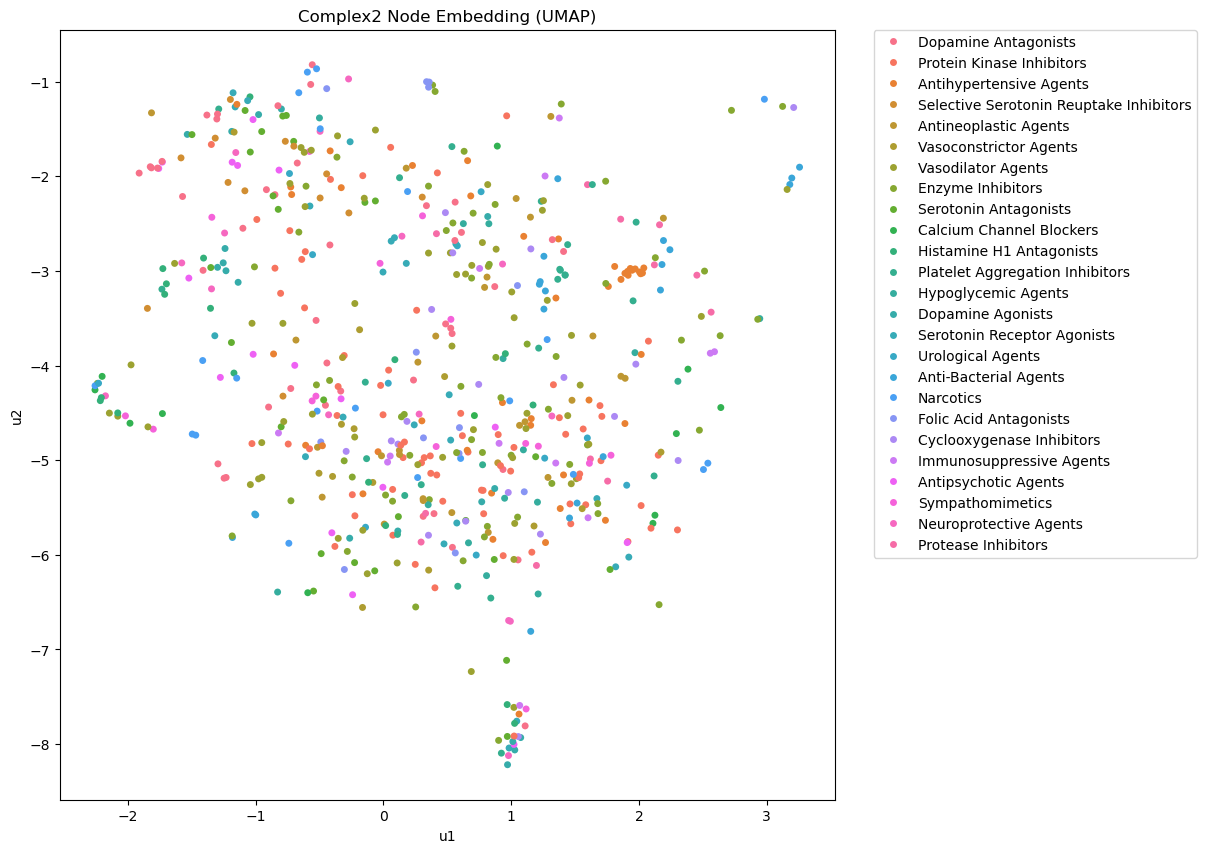

In [35]:
reducer = umap.UMAP(n_components=2, metric='euclidean')
u = reducer.fit_transform(z_drug) 

df = pd.DataFrame(u, columns=['u1', 'u2'], 
                        index=data.node_name_dict['drug'])
df = df.merge(targ_info, left_index=True, right_index=True, how='inner')


df = df.assign(pmesh_last = df.pharm_mesh.str.split('|').str[-1])
common_pmesh = df.groupby('pmesh_last').count()[['u1']].sort_values('u1', ascending=False).head(25).index.tolist()
df = df[df.pmesh_last.isin(common_pmesh)]

plt.figure(figsize=(10, 10))
sbn.scatterplot(data=df, x='u1', y='u2', linewidth=0, alpha=1., s=25, hue='pmesh_last')#
plt.title('Complex2 Node Embedding (UMAP)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show() 

In [9]:
rel_names = ['->'.join(x) for x in data.edge_reltype.keys()]

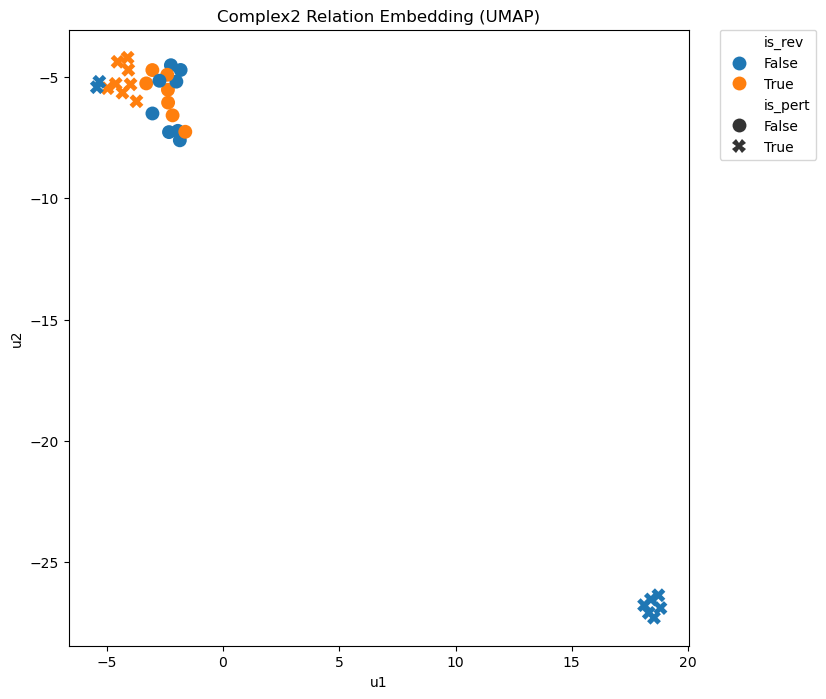

In [10]:
z_rel_real = model.relation_real_embedding.weight.data.detach().cpu().numpy() 
z_rel_imag = model.relation_imag_embedding.weight.data.detach().cpu().numpy() 

z_rel = np.concatenate([z_rel_real, z_rel_imag], axis=1) 

reducer = umap.UMAP(n_components=2, metric='cosine', n_neighbors=5,
                    min_dist=0.1, spread=1.0, n_epochs=2000)


u = reducer.fit_transform(z_rel) 

df = pd.DataFrame(u, columns=['u1', 'u2']).assign(rel_name=rel_names)
df = df.assign(is_pert = lambda x: x.rel_name.str.contains('perturbation'))
df = df.assign(is_rev = lambda x: x.rel_name.str.contains('rev'))

plt.figure(figsize=(8, 8))
sbn.scatterplot(data=df, x='u1', y='u2', linewidth=0, alpha=1.0, s=100, hue='is_rev', style='is_pert')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Complex2 Relation Embedding (UMAP)')
plt.show() 


